# Collaboration and Competition

---

## Importing Libraries

In [5]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from maddpg_agent import MaddpgAgent
from collections import deque


import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1. Start the Environment

In [2]:
# env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")
env = UnityEnvironment(file_name="/mnt/store_data/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
states.shape

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


(2, 24)

### 5. Train MaddpgAgent Agent:

In [7]:
random_seed = 42
agent = MaddpgAgent(state_size=state_size, action_size=action_size,random_seed=random_seed, n_agents=num_agents)

### 6. Define algorithm

In [10]:
def maddpg(agent, env, max_t=1000, window_size=100, score_threshold=1, print_interval=100, episodes=5000):
    
    # Initialize deque to store episode scores
    scores_deque = deque(maxlen=window_size) 
    # Initialize deque to store local episode scores
    local_scores_deque = deque(maxlen=window_size//2)
    # Initialize list to store all episode scores
    scores = []
    # Initialize the previous average score
    old_average_score = 0    
    
    # Print a message indicating the start of training
    print("Training on {} started...".format(agent.device))
    
    # Loop through the specified number of episodes
    for i_episode in range(1, episodes+1):
        # Reset the environment and obtain initial state information
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        # Initialize episode scores
        episode_scores = np.zeros(num_agents) 
        
        # Loop through the maximum number of time steps per episode
        for _ in range(max_t):
            # Select actions for the current states
            actions = agent.act(states)
            # Send the actions to the environment and receive the next states, rewards, and done information
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            # Update the agent based on the observed states, actions, rewards, and next states
            agent.step(states=states, actions=actions, rewards=[reward*10 if reward <0 else reward  for reward in rewards], next_states=next_states, dones=dones)
            # Update the episode scores
            episode_scores += np.array(rewards)
            states = next_states
            # Break if any agent is done
            if np.any(dones):
                break

        # Calculate the maximum score for the episode
        episode_score = np.max(episode_scores) 
        # Append the episode score to the scores deque
        scores_deque.append(episode_score)
        # Append the episode score to the local scores deque
        local_scores_deque.append(episode_score)
        # Append the episode score to the scores list
        scores.append(episode_score)
        # Calculate the average score
        average_score = np.mean(scores_deque)
        # Calculate the local average score
        max_local_score= np.mean(local_scores_deque)

        # Print the episode number, average score, local average score, current score, and all episode scores at specified intervals
        if i_episode % (print_interval//2) == 0:
            print('\rEpisode: {}\tAverage Score: {:.3f}\tlocal average Score: {:.3f}\tCurrent Score: {:.3f}\tScores : {:.3f} {:.3f}'.format(i_episode, average_score,max_local_score, episode_score , *episode_scores))
       
        # Save the agent's state to checkpoint files if the average score exceeds the previous average score by 5 or more
        if average_score > score_threshold/2:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_2_agents.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_2_agents.pth')
        
        # Check if the score threshold is reached and print a message if so, then save the agent's state to a checkpoint file
        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.3f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_2_agents.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_2_agents.pth')
            break
    
    # Save the scores to a numpy file
    np.save('maddpg_scores.npy', scores)
    # Return the scores
    return scores

#### Run training

In [11]:
scores = maddpg(agent, env, max_t=1000, window_size=100, score_threshold=1, print_interval=100, episodes=5000)

Training on cuda:0 started...
Episode: 50	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 100	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : -0.010 0.000
Episode: 150	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : -0.010 0.000
Episode: 200	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 250	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 300	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : -0.010 0.000
Episode: 350	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : -0.010 0.000
Episode: 400	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 450	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 500	Average Score: 0.000	l

### 7. Plot results

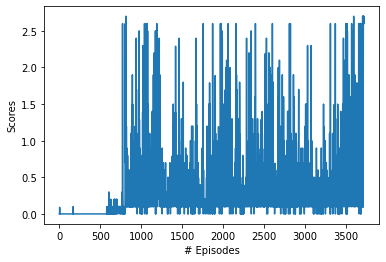

In [ ]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.savefig('maddpg_scores_plot_curve.png')
plt.show()

### 7. Run Inference mode

In [ ]:
agent = MaddpgAgent(state_size=state_size, action_size=action_size,random_seed=0)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_2_agents.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_2_agents.pth'))

<All keys matched successfully>

In [13]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
step = 0
while step<1000:
    step+=1
    actions = agent.act(states)                      # select an action
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    rewards = env_info.rewards                   # get the reward
    done = env_info.local_done                  # see if episode has finished
    scores += rewards                                # update the score
    states = next_states                             # roll over the state to next time step
    if np.any(dones):
        break
    
print("Score: {}".format(np.mean(scores)))

Score: 2.650000039488077


In [14]:
env.close()